In [1]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [4]:
from IPython.display import Image
Image(url='notMNIST_small/A/MDEtMDEtMDAudHRm.png')

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825029
Standard deviation: 0.44312057
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.007563033
Standard deviation: 0.45449144
Pickling ./notMNIST_large/C.pickle.
./notMNIST_large/C
Full dataset tensor: (52912, 2

In [7]:
print(train_datasets)

['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle', './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']


In [8]:
print(test_datasets)

['./notMNIST_small/A.pickle', './notMNIST_small/B.pickle', './notMNIST_small/C.pickle', './notMNIST_small/D.pickle', './notMNIST_small/E.pickle', './notMNIST_small/F.pickle', './notMNIST_small/G.pickle', './notMNIST_small/H.pickle', './notMNIST_small/I.pickle', './notMNIST_small/J.pickle']


Text(0.5,1,'Char a')

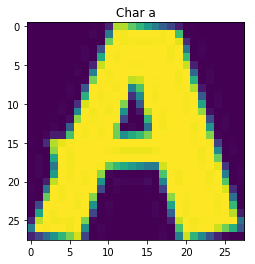

In [9]:
with open(train_datasets[0], 'rb') as f:
        letter_set = pickle.load(f)
plt.imshow(letter_set[0])
plt.title("Char a")

Text(0.5,1,'Char a')

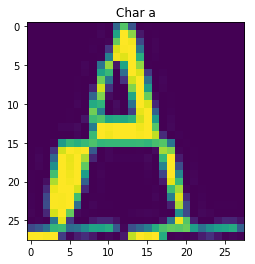

In [10]:
with open(train_datasets[0], 'rb') as f:
        letter_set = pickle.load(f)
plt.imshow(letter_set[1])
plt.title("Char a")

In [11]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [12]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [13]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [14]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


In [15]:
with open('notMNIST.pickle', 'rb') as f:
        load_data = pickle.load(f)

In [16]:
print(load_data['train_dataset'][0][0][0])

-0.5


In [17]:
print(load_data['test_dataset'])

[[[ 0.1509804   0.23333333  0.2254902  ... -0.5        -0.5
   -0.5       ]
  [-0.24901961 -0.13137256  0.30784315 ... -0.5        -0.5
   -0.5       ]
  [-0.5        -0.5        -0.33529413 ... -0.4882353  -0.5
   -0.5       ]
  ...
  [-0.5        -0.5        -0.28039217 ... -0.4882353  -0.5
   -0.5       ]
  [-0.29215688 -0.12745099  0.32352942 ... -0.5        -0.5
   -0.5       ]
  [ 0.45686275  0.5         0.5        ... -0.5        -0.5
   -0.5       ]]

 [[-0.5        -0.5        -0.5        ... -0.01372549 -0.18235295
   -0.31960785]
  [-0.5        -0.5        -0.5        ...  0.49607843  0.5
    0.38235295]
  [-0.5        -0.5        -0.5        ...  0.47254902  0.5
    0.17843138]
  ...
  [-0.49607843 -0.5        -0.48431373 ... -0.5        -0.5
   -0.5       ]
  [-0.5        -0.49607843 -0.4882353  ... -0.5        -0.5
   -0.5       ]
  [-0.5        -0.5        -0.49607843 ... -0.5        -0.5
   -0.5       ]]

 [[-0.5        -0.5        -0.5        ... -0.5        -0.4098039

In [18]:
np.intersect1d(load_data['train_dataset'],load_data['test_dataset'])

array([-0.5       , -0.49607843, -0.49215686, -0.4882353 , -0.48431373,
       -0.48039216, -0.4764706 , -0.47254902, -0.46862745, -0.46470588,
       -0.46078432, -0.45686275, -0.45294118, -0.4490196 , -0.44509804,
       -0.44117647, -0.4372549 , -0.43333334, -0.42941177, -0.4254902 ,
       -0.42156863, -0.41764706, -0.4137255 , -0.40980393, -0.40588236,
       -0.4019608 , -0.39803922, -0.39411765, -0.39019608, -0.38627452,
       -0.38235295, -0.37843138, -0.3745098 , -0.37058824, -0.36666667,
       -0.3627451 , -0.35882354, -0.35490197, -0.3509804 , -0.34705883,
       -0.34313726, -0.3392157 , -0.33529413, -0.33137256, -0.327451  ,
       -0.32352942, -0.31960785, -0.3156863 , -0.31176472, -0.30784315,
       -0.30392158, -0.3       , -0.29607844, -0.29215688, -0.2882353 ,
       -0.28431374, -0.28039217, -0.2764706 , -0.27254903, -0.26862746,
       -0.2647059 , -0.26078433, -0.25686276, -0.2529412 , -0.24901961,
       -0.24509804, -0.24117647, -0.2372549 , -0.23333333, -0.22

In [19]:
print(len(np.intersect1d(load_data['train_dataset'],load_data['test_dataset'])))

256


Number of overlaps: 1300


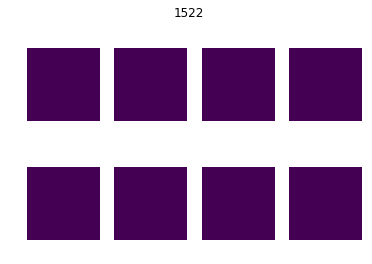

Overlapping images removed from test_dataset:  1300
Overlapping images removed from valid_dataset:  1084
Training: (200000, 28, 28) (200000,)
Validation: (8916,) (8916,)
Testing: (8700, 28, 28) (8700,)
Compressed pickle size: 683314746


In [20]:
import hashlib


def extract_overlap_hash_where(dataset_1, dataset_2):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap


def display_overlap(overlap, source_dataset, target_dataset):
    overlap = {k: v for k, v in overlap.items() if len(v) >= 3}
    item = np.random.choice(list(overlap.keys()))
    imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i + 1)
        plt.axis('off')
        plt.imshow(img)

    plt.show()


def sanitize(dataset_1, dataset_2, labels_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = []  # list of indexes
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)


overlap_test_train = extract_overlap_hash_where(test_dataset, train_dataset)
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset, train_dataset)

test_dataset_sanit, test_labels_sanit = sanitize(test_dataset, train_dataset, test_labels)
print('Overlapping images removed from test_dataset: ', len(test_dataset) - len(test_dataset_sanit))
valid_dataset_sanit, valid_labels_sanit = sanitize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed from valid_dataset: ', len(valid_dataset) - len(valid_dataset_sanit))
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_labels_sanit.shape, valid_labels_sanit.shape)
print('Testing:', test_dataset_sanit.shape, test_labels_sanit.shape)
pickle_file_sanit = 'notMNIST_sanit.pickle'

try:
    f = open(pickle_file_sanit, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset_sanit,
        'valid_labels': valid_labels_sanit,
        'test_dataset': test_dataset_sanit,
        'test_labels': test_labels_sanit,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)

Accuracy: 0.5702 when sample_size= 50


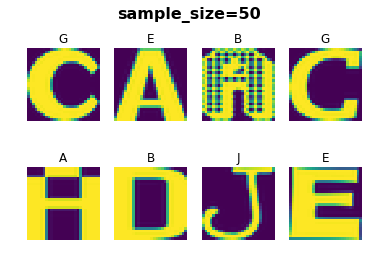

Accuracy: 0.7271 when sample_size= 100


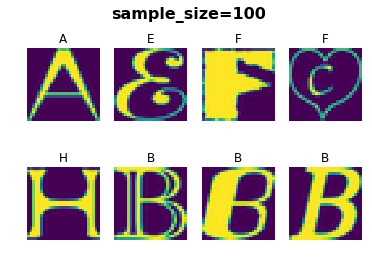

Accuracy: 0.832 when sample_size= 1000


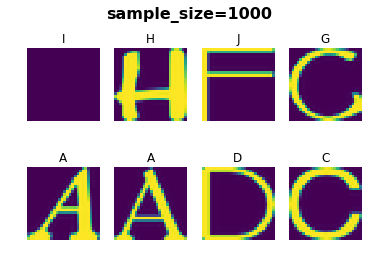

Accuracy: 0.8459 when sample_size= 5000


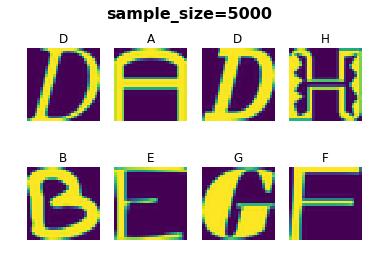

Accuracy: 0.8908 when sample_size= 200000


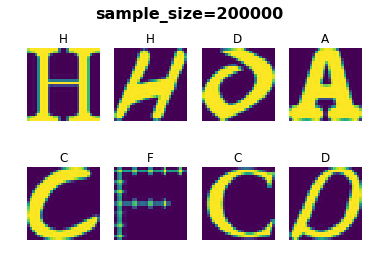

In [21]:
import random
def disp_sample_dataset(dataset, labels, title=None):
    fig = plt.figure()
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    items = random.sample(range(len(labels)), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i + 1)
        plt.axis('off')
        plt.title(chr(ord('A') + labels[item]))
        plt.imshow(dataset[item])
    plt.show()


def train_and_predict(sample_size):
    regr = LogisticRegression()
    X_train = train_dataset[:sample_size].reshape(sample_size, 784)
    y_train = train_labels[:sample_size]
    regr.fit(X_train, y_train)

    X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
    y_test = test_labels

    pred_labels = regr.predict(X_test)

    print('Accuracy:', regr.score(X_test, y_test), 'when sample_size=', sample_size)
    disp_sample_dataset(test_dataset, pred_labels, 'sample_size=' + str(sample_size))


for sample_size in [50, 100, 1000, 5000, len(train_dataset)]:
    train_and_predict(sample_size)